# L1 and L2 model comparison for housing price prediction

### Aim to build a model using L1 and L2 regression methods to compare their predictions on Sale Price of a house and estimate impact of statistically significant features



---


#### Importing libraries

In [270]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [271]:
housing =  pd.read_csv("train.csv")
null_counts = housing.isnull().sum()
print(null_counts[null_counts > 0])


LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


#### Removing columns with all null values and filling null values

In [272]:
housing.drop(columns=["MiscVal","3SsnPorch","PoolArea","Id","Utilities",
                      "Alley","MasVnrType","FireplaceQu","PoolQC","Fence","MiscFeature"], inplace=True)
housing = housing.fillna(method='pad')

#### Storing feature names

In [273]:
var_catlist = []
print("\nCategorical values with string:")
for col in housing.select_dtypes(include=["object"]):
  var_catlist.append(col)
print(len(var_catlist))

var_numlist = []
print("\nCategorical values with numbers:")
for col in housing.select_dtypes(include=["int64", "float64"]):
  var_numlist.append(col)
print(len(var_numlist))


Categorical values with string:
36

Categorical values with numbers:
34


### EDA

#### EDA of Numerical features

IndexError: index 8 is out of bounds for axis 0 with size 8

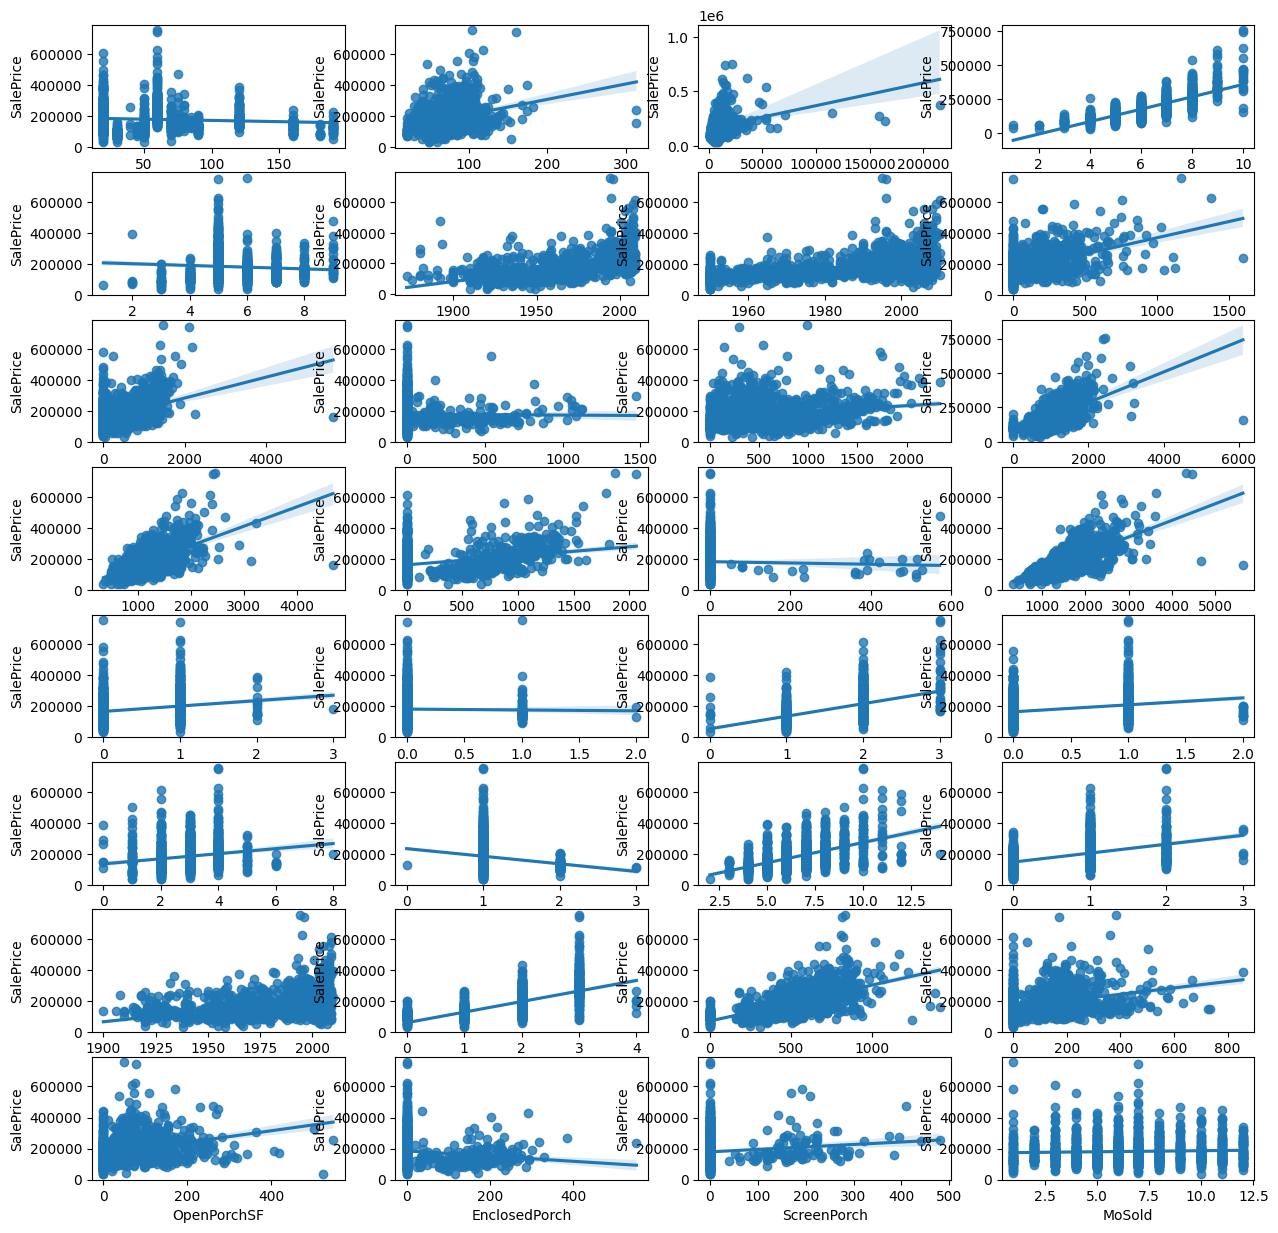

In [274]:
# prompt: plot housing[var_numlist] against "saleprice'. in a figure of 8 rows and 4 columns

fig, axes = plt.subplots(8, 4, figsize=(15, 15))
i = 0
j = 0
for col in var_numlist:
  if j == 4:
    j = 0
    i += 1
  sns.regplot(x=col, y="SalePrice", data=housing, ax=axes[i, j])
  j += 1


All numerical features seem to show more or less linear relationship with Target variable "SalePrice"

#### EDA of Categorical valriables

IndexError: index 8 is out of bounds for axis 0 with size 8

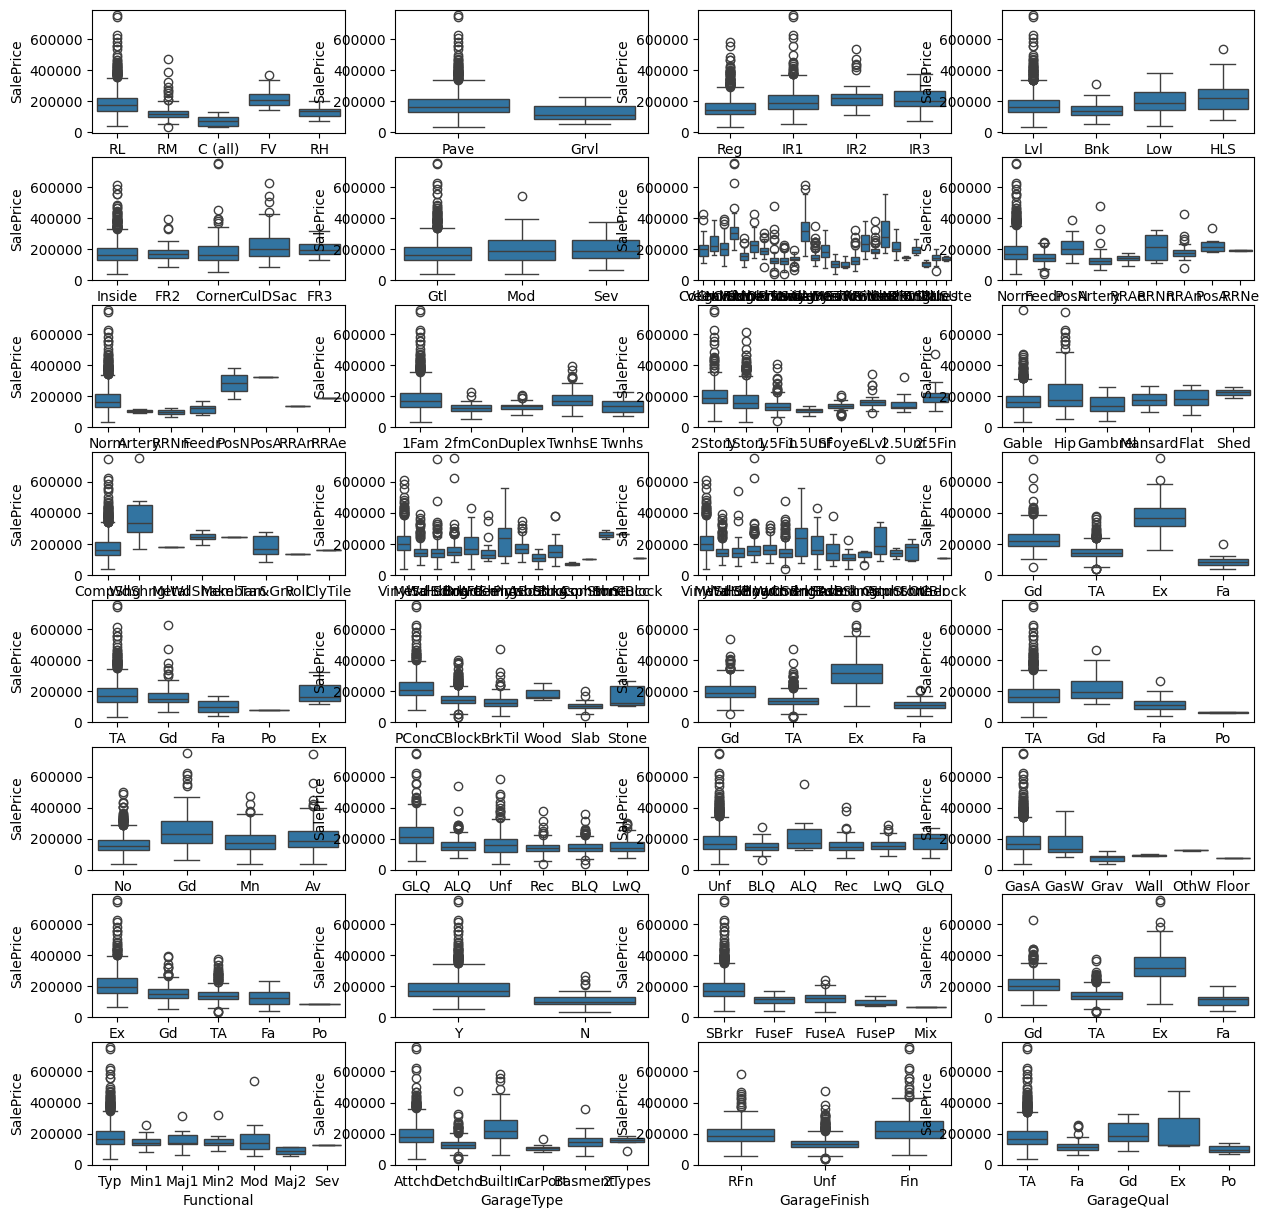

In [275]:
# prompt: boxplot all var_catlist in a figure of 8 rows and 4 columns

fig, axes = plt.subplots(8, 4, figsize=(15, 15))
i = 0
j = 0
for col in var_catlist:
  if j == 4:
    j = 0
    i += 1
  sns.boxplot(x=col, y="SalePrice", data=housing, ax=axes[i, j])
  j += 1


All categorical features show fair class division.

For the sake of a better model,we will part the dataframe with and without the following features :

['Neighborhood','Exterior1st','Exterior2nd','Foundation','Condition1','Roofstyle','Heating']




In [276]:
eda_remove = ['Neighborhood','Exterior1st','Exterior2nd','Foundation','Condition1','RoofStyle','Heating']
housing_eda = housing.drop(housing[eda_remove],axis=1)
var_catlist_eda =  [x for x in var_catlist if x not in eda_remove]

### Data Preparation

#### Creating Dummy variables for categorical features

In [277]:
status = pd.get_dummies(housing[var_catlist], drop_first = True)
housing = housing.drop(housing[var_catlist], axis=1)

var_catlist = []
for col in status.select_dtypes(include=["bool"]):
  var_catlist.append(col)


status = status.replace(to_replace = True, value = 1)
status = status.replace(to_replace = False, value = 0)
housing = pd.concat([housing, status], axis = 1)


In [278]:
status = pd.get_dummies(housing_eda[var_catlist_eda], drop_first = True)
housing_eda = housing_eda.drop(housing_eda[var_catlist_eda], axis=1)

var_catlist_eda = []
for col in status.select_dtypes(include=["bool"]):
  var_catlist_eda.append(col)


status = status.replace(to_replace = True, value = 1)
status = status.replace(to_replace = False, value = 0)
housing_eda = pd.concat([housing_eda, status], axis = 1)



In [279]:
print("Shape non EDA : ", housing.shape)
print("Shape EDA: ", housing_eda.shape)

Shape non EDA :  (1460, 226)
Shape EDA:  (1460, 150)


Currently we have :
* 149 features if columns after EDA are dropped
* 225 features if columns are not dropped as per EDA

Moving ahead we will test for both.

Note: _eda is used for all code related to EDA features

#### Scaling Features

In [280]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [281]:
X = housing.drop('SalePrice',axis=1)
y = housing[['SalePrice']]

X_eda = housing_eda.drop('SalePrice',axis=1)
y_eda = housing_eda[['SalePrice']]

In [282]:
#Scaling non eda
X_scaled = preprocessing.scale(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

y_scaled = preprocessing.scale(y)
y_scaled = pd.DataFrame(y_scaled, columns= y.columns)


#Scaling EDA
X_scaled_eda = preprocessing.scale(X_eda)
X_scaled_eda = pd.DataFrame(X_scaled_eda, columns=X_eda.columns)

y_scaled_eda = preprocessing.scale(y_eda)
y_scaled_eda = pd.DataFrame(y_scaled_eda, columns= y_eda.columns)

#### Splitting data

In [283]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.30, random_state=1)
X_train_eda, X_test_eda, y_train_eda, y_test_eda = train_test_split(X_scaled_eda, y_scaled_eda, test_size=0.30, random_state=1)

### Traing and building model


#### Generic model comparison function

This is a generic model comparison function to get an approx model scores. We will later fine tune the model

In [284]:
def model_comparison(X_train_sm,X_test_sm,y_train,y_test):
  regression_model = LinearRegression()
  regression_model.fit(X_train_sm, y_train)
  print("\n######################################### Regression ########################################")
  y_pred_train = regression_model.predict(X_train_sm)
  y_pred_test=regression_model.predict(X_test_sm)
  metric =[]
  r2_train_lr=r2_score(y_train, y_pred_train)
  print("R2 score train: ",r2_train_lr)
  metric.append(r2_train_lr)
  r2_test_lr = r2_score (y_test, y_pred_test)
  print("R2 score test: ",r2_test_lr)
  metric.append(r2_test_lr)

  print("\n######################################### Regression ########################################")



  print("Linear regression train score : ", regression_model.score(X_train_sm, y_train))
  print("Linear regression test score : ", regression_model.score(X_test_sm, y_test))
  print("\n############################################ Lasso ##########################################")
  lasso = Lasso(alpha=0.1)
  lasso.fit(X_train_sm,y_train)


  print("Lasso Regression train score : ",lasso.score(X_train_sm, y_train))
  print("Lasso Regression test score : ",lasso.score(X_test_sm, y_test))
  print("\n############################################ Ridge ##########################################")
  ridge = Ridge(alpha=.3) #coefficients are prevented to become too big by this alpha value
  ridge.fit(X_train_sm,y_train)


  print("Ridge Regression train score : ",ridge.score(X_train_sm, y_train))
  print("Ridge Regression test score : ",ridge.score(X_test_sm, y_test))

#### First model comparison

In [285]:
model_comparison(X_train,X_test, y_train, y_test)


######################################### Regression ########################################
R2 score train:  0.9314319688914199
R2 score test:  -1.2126774581451607e+22

######################################### Regression ########################################
Linear regression train score :  0.9314319688914199
Linear regression test score :  -1.2126774581451607e+22

############################################ Lasso ##########################################
Lasso Regression train score :  0.7518637311772582
Lasso Regression test score :  0.7974277417781356

############################################ Ridge ##########################################
Ridge Regression train score :  0.931406293283596
Ridge Regression test score :  0.7535877776982591


Poor results. We observe no statistical significant values in any model apart from Ridge regression

In [287]:
model_comparison(X_train_eda,X_test_eda, y_train_eda, y_test_eda)


######################################### Regression ########################################
R2 score train:  0.9091842719585298
R2 score test:  -1.4590948488763595e+22

######################################### Regression ########################################
Linear regression train score :  0.9091842719585298
Linear regression test score :  -1.4590948488763595e+22

############################################ Lasso ##########################################
Lasso Regression train score :  0.7426166492058939
Lasso Regression test score :  0.7949490497392052

############################################ Ridge ##########################################
Ridge Regression train score :  0.9091629989659886
Ridge Regression test score :  0.7211690754874525


Poor results in EDA Variables as well. We observe no statistical significant values in any model apart from Ridge regression

#### Using Vif to extract features

In [288]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [289]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif_3= vif[vif['VIF'] < 20]
vif_features = vif_3.Features

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [290]:
X_train = X_train[vif_features]
X_test = X_test[vif_features]
model_comparison(X_train,X_test,y_train, y_test)


######################################### Regression ########################################
R2 score train:  0.8894518767751434
R2 score test:  0.8332983871706853

######################################### Regression ########################################
Linear regression train score :  0.8894518767751434
Linear regression test score :  0.8332983871706853

############################################ Lasso ##########################################
Lasso Regression train score :  0.7395669385174937
Lasso Regression test score :  0.7575879528434718

############################################ Ridge ##########################################
Ridge Regression train score :  0.8894516275635623
Ridge Regression test score :  0.83336740450867


In [291]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif_3= vif[vif['VIF'] < 10]
vif_features = vif_3.Features
X_train = X_train[vif_features]
X_test = X_test[vif_features]
model_comparison(X_train,X_test,y_train, y_test)


######################################### Regression ########################################
R2 score train:  0.8871334790947889
R2 score test:  0.8270435160652573

######################################### Regression ########################################
Linear regression train score :  0.8871334790947889
Linear regression test score :  0.8270435160652573

############################################ Lasso ##########################################
Lasso Regression train score :  0.739547639666169
Lasso Regression test score :  0.7575677001355268

############################################ Ridge ##########################################
Ridge Regression train score :  0.8871332354197752
Ridge Regression test score :  0.8275294281103487


We observse statistically significant R2 scores. Here we have High VIF and hence 172 features. We will next observe VIF < 5 and VIF < 10

In [292]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif_3= vif[vif['VIF'] < 10]
vif_features = vif_3.Features
X_train = X_train[vif_features]
X_test = X_test[vif_features]
model_comparison(X_train,X_test,y_train, y_test)


######################################### Regression ########################################
R2 score train:  0.8871334790947889
R2 score test:  0.8271687012194178

######################################### Regression ########################################
Linear regression train score :  0.8871334790947889
Linear regression test score :  0.8271687012194178

############################################ Lasso ##########################################
Lasso Regression train score :  0.739547906848715
Lasso Regression test score :  0.757568731782817

############################################ Ridge ##########################################
Ridge Regression train score :  0.8871332354197752
Ridge Regression test score :  0.8275294281103486


In [293]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif_3= vif[vif['VIF'] < 5]
vif_features = vif_3.Features
X_train = X_train[vif_features]
X_test = X_test[vif_features]
model_comparison(X_train,X_test,y_train, y_test)


######################################### Regression ########################################
R2 score train:  0.8581009842782964
R2 score test:  -1.6740375300859607e+21

######################################### Regression ########################################
Linear regression train score :  0.8581009842782964
Linear regression test score :  -1.6740375300859607e+21

############################################ Lasso ##########################################
Lasso Regression train score :  0.7061217205729682
Lasso Regression test score :  0.7303765072457877

############################################ Ridge ##########################################
Ridge Regression train score :  0.8581008936306159
Ridge Regression test score :  0.8011828441998603


We observe that wth VIF < 10 we have 169 features which are showing statistical significant R2 squares

#### Grid Search for hyperparameter tuning

In [296]:
from sklearn.model_selection import GridSearchCV

In [301]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.30, random_state=1)

vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif_3= vif[vif['VIF'] < 10]
vif_features = vif_3.Features
X_train = X_train[vif_features]
X_test = X_test[vif_features]

model_comparison(X_train,X_test,y_train, y_test)

#list of alphas to tune if value too high
params =  {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1,
0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()
# cross validation
folds = 5
model_cv = GridSearchCV(
    estimator = ridge,
    param_grid = params,
    scoring = 'neg_mean_absolute_error',
    cv = folds,
    return_train_score=True,
    verbose = 1)
model_cv.fit(X_train, y_train)



/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



######################################### Regression ########################################
R2 score train:  0.8617356500663803
R2 score test:  0.8274188092654875

######################################### Regression ########################################
Linear regression train score :  0.8617356500663803
Linear regression test score :  0.8274188092654875

############################################ Lasso ##########################################
Lasso Regression train score :  0.7351443497198733
Lasso Regression test score :  0.7565619673769346

############################################ Ridge ##########################################
Ridge Regression train score :  0.8617355788086895
Ridge Regression test score :  0.8274124435528843
Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [302]:
print(model_cv.best_params_)

{'alpha': 500}


In [303]:
#list of alphas to tune if value too high
params =  {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1,
0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Lasso()
# cross validation
folds = 5
model_cv = GridSearchCV(
    estimator = ridge,
    param_grid = params,
    scoring = 'neg_mean_absolute_error',
    cv = folds,
    return_train_score=True,
    verbose = 1)
model_cv.fit(X_train, y_train)


Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [304]:
print(model_cv.best_params_)

{'alpha': 0.01}


#### Final Model

In [307]:
lasso = Lasso(alpha=0.01)
lasso.fit(X_train,y_train)

#Lasso
print("\n############################################ Ridge ##########################################")
print("Lasso Regression train score : ",lasso.score(X_train, y_train))
print("Lasso Regression test score : ",lasso.score(X_test, y_test))
for i,col in enumerate(X_train):
  print ("Lasso model coefficients for {} is {}:".format(col,lasso.coef_[i]))

print("\n############################################ Ridge ##########################################")
ridge = Ridge(alpha=500) #coefficients are prevented to become too big by this alpha value
ridge.fit(X_train,y_train)

#Ridge
print("Ridge Regression train score : ",ridge.score(X_train, y_train))
print("Ridge Regression test score : ",ridge.score(X_test, y_test))
for i,col in enumerate(X_train.columns):
    print ("Ridge model coefficients for {} is {}:".format(col,ridge.coef_[0][i]))


############################################ Ridge ##########################################
Lasso Regression train score :  0.8483425913924912
Lasso Regression test score :  0.8350208950662362
Lasso model coefficients for HouseStyle_2Story is -0.040363621455469186:
Lasso model coefficients for Foundation_PConc is 0.05666476242934525:
Lasso model coefficients for Neighborhood_NWAmes is -0.0:
Lasso model coefficients for KitchenQual_Gd is -0.02826843549170637:
Lasso model coefficients for GarageCars is 0.07265835419557139:
Lasso model coefficients for GarageArea is 0.07121627609419516:
Lasso model coefficients for Neighborhood_Gilbert is -0.00349962227321217:
Lasso model coefficients for BsmtQual_Gd is -0.04922324723918878:
Lasso model coefficients for Neighborhood_NridgHt is 0.12417882805040631:
Lasso model coefficients for Neighborhood_Crawfor is 0.07224354129274811:
Lasso model coefficients for MSZoning_RH is 0.0:
Lasso model coefficients for Foundation_CBlock is 0.0:
Lasso model c

### Questions based code

#### Q1 doubling of alpha values

In [308]:
lasso = Lasso(alpha=0.02)
lasso.fit(X_train,y_train)

#Lasso
print("\n############################################ Ridge ##########################################")
print("Lasso Regression train score : ",lasso.score(X_train, y_train))
print("Lasso Regression test score : ",lasso.score(X_test, y_test))
for i,col in enumerate(X_train):
  print ("Lasso model coefficients for {} is {}:".format(col,lasso.coef_[i]))

print("\n############################################ Ridge ##########################################")
ridge = Ridge(alpha=1000) #coefficients are prevented to become too big by this alpha value
ridge.fit(X_train,y_train)

#Ridge
print("Ridge Regression train score : ",ridge.score(X_train, y_train))
print("Ridge Regression test score : ",ridge.score(X_test, y_test))
for i,col in enumerate(X_train.columns):
    print ("Ridge model coefficients for {} is {}:".format(col,ridge.coef_[0][i]))


############################################ Ridge ##########################################
Lasso Regression train score :  0.8296003336890672
Lasso Regression test score :  0.8279033628113015
Lasso model coefficients for HouseStyle_2Story is -0.0067704201037942485:
Lasso model coefficients for Foundation_PConc is 0.03947030510794458:
Lasso model coefficients for Neighborhood_NWAmes is -0.0:
Lasso model coefficients for KitchenQual_Gd is -0.0:
Lasso model coefficients for GarageCars is 0.07118766967587054:
Lasso model coefficients for GarageArea is 0.07655312137563108:
Lasso model coefficients for Neighborhood_Gilbert is -0.0:
Lasso model coefficients for BsmtQual_Gd is -0.025999058059036843:
Lasso model coefficients for Neighborhood_NridgHt is 0.12261178633729806:
Lasso model coefficients for Neighborhood_Crawfor is 0.06408911202038463:
Lasso model coefficients for MSZoning_RH is 0.0:
Lasso model coefficients for Foundation_CBlock is 0.0:
Lasso model coefficients for Neighborhood_I